In [1]:
import numpy as np

X = np.loadtxt("mnist2500_X.txt")
labels = np.loadtxt("mnist2500_labels.txt")
testX = X[:50, ]

# Original code

In [33]:
def squared_euclidean_dist(v1, v2): 
    '''
    A function that takes in two vectors as inputs and returns the squared euclidean distance between them.
    '''
    return np.sum((v1 - v2)**2)


def pairwise_distance(M):
    '''
    This function computes a pairwise distance matrix using
    the squared euclidean norm. Returns the negative of the squared
    norm, since it usually the input to the function
    
    Input: M is a nxD matrix
    Output: A Pairwise distance matrix of dimension nxn. 
            The PD_ij entry contains the euclidean distance between row X_i and X_j
    '''
            
    num_rows = M.shape[0]
    PD = np.zeros((num_rows, num_rows))
    
    for i in range(num_rows):
        v1 = M[i,:]
        for j in range(num_rows):
            v2 = M[j,:]
            PD[i,j] = PD[j,i]= -squared_euclidean_dist(v1, v2)
            
    return PD


def prob_matrix(dist_X, sigmas):
    """
    Returns the matrix of conditional probabilities p_j|i.
    :param dist_X: the pairwise distance matrix
    :param sigmas: a vector of sigma values corresponding to each row of the distance matrix
    """
    x = dist_X / (2*(sigmas**2).reshape((-1, 1)))
    expx = np.exp(x)

    # Since we do not sum over k = l, we set the diagonals to zero
    np.fill_diagonal(expx, 0.)
    # Avoid division by 0 errors
    expx = expx + 1e-8

    # Calculate Normalized Exponential
    rowsums = expx.sum(axis=1).reshape((-1, 1))
    normalized_exp = expx / rowsums

    return normalized_exp

def perplexity(prob_X):
    """
    Calculates the perplexity of each row of the probability matrix.
    :param prob_X: the conditional probability matrix
    :return: a vector of perplexity values
    """
    entropy = -np.sum(prob_X * np.log2(prob_X), axis=1)
    return 2**entropy

def binary_search(f, target_perplexity, lower=1e-10, upper=1000, tol=1e-8, max_iter=10000):
    """
    Performs a binary search for the value of sigma that corresponds to the target perplexity.
    :param f: function to calculate perplexity
    :param target_perplexity: the specified perplexity value
    :param lower: initial lower bound
    :param upper: initial upper bound
    :param tol: tolerance to determine if the perplexity value is close enough to the target
    :param max_iter: maximum number of iterations of the loop
    :return: the optimal value of sigma
    """
    for i in range(max_iter):
        sigma = (lower + upper) / 2
        perp = f(sigma)
        if np.abs(perp - target_perplexity) < tol:
            return sigma
        if perp > target_perplexity:
            upper = sigma
        else:
            lower = sigma
    return sigma

def get_sigmas(dist_X, target_perplexity):
    """
    Finds the sigma for each row of the distance matrix based on the target perplexity.
    :param dist_X: the pairwise distance matrix
    :param target_perplexity: the specified perplexity value
    :return: a vector of sigma values corresponding to each row of the distance matrix
    """
    nrows = dist_X.shape[0]
    sigmas = np.zeros(nrows)

    for i in range(nrows):
        f = lambda sigma: perplexity(prob_matrix(dist_X[i:i + 1, :], np.array(sigma)))
        best_sigma = binary_search(f, target_perplexity)
        sigmas[i] = best_sigma
    return sigmas

def get_pmatrix(X, perplexity):
    """
    Calculates the final probability matrix using the pairwise affinities/conditional probabilities.
    :param M: the matrix of data to be converted
    :param perplexity: the specified perplexity
    :return: the joint probability matrix p_ij
    """
    # get the pairwise distances
    dist = pairwise_distance(X)
    # get the sigmas
    sigmas = get_sigmas(dist, perplexity)
    # get the matrix of conditional probabilities
    prob = prob_matrix(dist, sigmas)
    p = (prob + prob.T) / (2*prob.shape[0])
    return p

def get_qmatrix(Y):
    """
    Calculates the low dimensional affinities joint matrix q_ij.
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: the joint probability matrix q_ij
    """
    q = 1 / (1 - pairwise_distance(Y))
    np.fill_diagonal(q, 0)
    return q / q.sum()

def gradient(P, Q, Y):
    """
    Calculates the gradient of the Kullback-Leibler divergence between P and Q
    :param P: the joint probability matrix
    :param Q: the Student-t based joint probability distribution matrix
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: a 2d array of the gradient values with the same dimensions as Y
    """
    pq_diff = np.expand_dims(P - Q, axis=2)
    y_diff = np.expand_dims(Y, axis=1) - np.expand_dims(Y, axis=0)
    dist = 1 - pairwise_distance(Y)
    inv_distance = np.expand_dims(1 / dist, axis=2)

    # multiply and sum over each row
    grad = 4 * (pq_diff * y_diff * inv_distance).sum(axis=1)
    return grad


def TSNE(X, perplexity=40, num_iter=1000, learning_rate=100, momentum_initial=0.5, momentum_final=0.8):
    """
    Performs t-SNE on a given matrix X.
    :param X: matrix of high dimensional data
    :param perplexity: cost function parameter
    :param num_iter: number of iterations
    :param learning_rate: learning rate
    :param momentum: momentum
    :return: matrix of 2D data representing X
    """
    # calculate joint probability matrix
    joint_p = get_pmatrix(X, perplexity)
    # early exaggeration to improve optimization
    joint_p = 4*joint_p 
    
    # initialize Y by sampling from Gaussian
    Y_t = np.random.RandomState(1).normal(0, 10e-4, [X.shape[0], 2])
    # initialize past iteration Y_{t-1}
    Y_t1 = Y_t.copy()
    # initialize past iteration Y_{t-2}
    Y_t2 = Y_t.copy()

    for i in range(num_iter):
        # compute low dimensional affinities matrix
        joint_q = get_qmatrix(Y_t)
        # compute gradient
        grad = gradient(joint_p, joint_q, Y_t)
        
        # update momentum
        if i < 250:
            momentum = momentum_initial
        else:
            momentum = momentum_final
        
        # update current Y
        Y_t = Y_t1 - learning_rate * grad + momentum * (Y_t1 - Y_t2)
        # update past iterations
        Y_t1 = Y_t.copy()
        Y_t2 = Y_t1.copy()
        
        # conclude early exaggeration and revert joint probability matrix back
        if i == 50:
            joint_p = joint_p / 4

    return Y_t

In [34]:
%timeit -r3 -n3 TSNE(X[:20, ])
%timeit -r3 -n3 TSNE(X[:50, ])
%timeit -r3 -n3 TSNE(X[:100, ])

16.4 s ± 83.2 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
45.6 s ± 50.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
3min 2s ± 355 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


# Profiling

In [3]:
import cProfile

cProfile.run('TSNE(testX)')

         50156235 function calls in 142.969 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
     4000    0.017    0.000    0.207    0.000 <__array_function__ internals>:2(expand_dims)
     2871    0.012    0.000    0.041    0.000 <__array_function__ internals>:2(fill_diagonal)
  5004370   15.422    0.000  107.148    0.000 <__array_function__ internals>:2(sum)
  5002500   23.823    0.000  130.925    0.000 <ipython-input-2-eee72a6edcaa>:1(squared_euclidean_dist)
     1000    0.046    0.000   71.105    0.071 <ipython-input-2-eee72a6edcaa>:114(get_qmatrix)
     1000    0.172    0.000   71.570    0.072 <ipython-input-2-eee72a6edcaa>:124(gradient)
        1    0.022    0.022  142.969  142.969 <ipython-input-2-eee72a6edcaa>:142(TSNE)
     1871    0.036    0.000    0.083    0.000 <ipython-input-2-eee72a6edcaa>:31(prob_matrix)
     1870    0.

# Optimization

In [44]:
def pairwise_distance_vec(X):
    """
    Returns the pairwise distance matrix for a matrix X using negative squared Euclidean distance.
    """
    sum_X = np.square(X).sum(axis=1)
    return -np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

def prob_matrix(dist_X, sigmas):
    """
    Returns the matrix of conditional probabilities p_j|i.
    :param dist_X: the pairwise distance matrix
    :param sigmas: a vector of sigma values corresponding to each row of the distance matrix
    """
    two_sig_sq = np.asarray(2*np.square(sigmas)).reshape((-1, 1))
    x = dist_X / two_sig_sq
    expx = np.exp(x)

    # Since we do not sum over k = l, we set the diagonals to zero
    np.fill_diagonal(expx, 0.)
    # Avoid division by 0 errors
    expx = expx + 1e-8

    # Calculate Normalized Exponential
    rowsums = expx.sum(axis=1).reshape((-1, 1))
    normalized_exp = expx / rowsums

    return normalized_exp

In [45]:
from numba import jit

pairwise_distance_nb = jit(pairwise_distance_vec, nopython=True, cache=True)
prob_matrix_nb = jit(prob_matrix)
perplexity_nb = jit(perplexity, nopython=True, cache=True)

In [46]:
def get_pmatrix(X, perplexity):
    """
    Calculates the final probability matrix using the pairwise affinities/conditional probabilities.
    :param M: the matrix of data to be converted
    :param perplexity: the specified perplexity
    :return: the joint probability matrix p_ij
    """
    # get the pairwise distances
    dist = pairwise_distance_nb(X)
    # get the sigmas
    sigmas = get_sigmas(dist, perplexity)
    # get the matrix of conditional probabilities
    prob = prob_matrix_nb(dist, sigmas)
    p = (prob + prob.T) / (2*prob.shape[0])
    return p

def get_qmatrix(Y):
    """
    Calculates the low dimensional affinities joint matrix q_ij.
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: the joint probability matrix q_ij
    """
    q = 1 / (1 - pairwise_distance_nb(Y))
    np.fill_diagonal(q, 0)
    return q / q.sum()

def gradient(P, Q, Y):
    """
    Calculates the gradient of the Kullback-Leibler divergence between P and Q
    :param P: the joint probability matrix
    :param Q: the Student-t based joint probability distribution matrix
    :param Y: low dimensional matrix representation of high dimensional matrix X
    :return: a 2d array of the gradient values with the same dimensions as Y
    """
    pq_diff = np.expand_dims(P - Q, axis=2)
    y_diff = np.expand_dims(Y, axis=1) - np.expand_dims(Y, axis=0)
    dist = 1 - pairwise_distance_nb(Y)
    inv_distance = np.expand_dims(1 / dist, axis=2)

    # multiply and sum over each row
    grad = 4 * (pq_diff * y_diff * inv_distance).sum(axis=1)
    return grad

def get_sigmas(dist_X, target_perplexity):
    """
    Finds the sigma for each row of the distance matrix based on the target perplexity.
    :param dist_X: the pairwise distance matrix
    :param target_perplexity: the specified perplexity value
    :return: a vector of sigma values corresponding to each row of the distance matrix
    """
    nrows = dist_X.shape[0]
    sigmas = np.zeros(nrows)

    for i in range(nrows):
        f = lambda sigma: perplexity_nb(prob_matrix_nb(dist_X[i:i + 1, :], np.asarray(sigma)))
        best_sigma = binary_search(f, target_perplexity)
        sigmas[i] = best_sigma
    return sigmas

In [49]:
%timeit -r3 -n3 TSNE(X[:20, ])
%timeit -r3 -n3 TSNE(X[:50, ])
%timeit -r3 -n3 TSNE(X[:100, ])

3.46 s ± 13.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
327 ms ± 4.53 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
844 ms ± 5.53 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [31]:
cProfile.run('TSNE(testX)')

         97441 function calls in 0.609 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(concatenate)
     4000    0.016    0.000    0.181    0.000 <__array_function__ internals>:2(expand_dims)
     1001    0.005    0.000    0.015    0.000 <__array_function__ internals>:2(fill_diagonal)
        1    0.016    0.016    0.609    0.609 <ipython-input-2-eee72a6edcaa>:142(TSNE)
     1870    0.013    0.000    0.013    0.000 <ipython-input-2-eee72a6edcaa>:51(perplexity)
       50    0.029    0.001    0.119    0.002 <ipython-input-2-eee72a6edcaa>:60(binary_search)
     2001    0.035    0.000    0.035    0.000 <ipython-input-25-baa80d069620>:1(pairwise_distance_vec)
     1871    0.044    0.000    0.044    0.000 <ipython-input-25-baa80d069620>:8(prob_matrix)
        1    0.000    0.000    0.121    0.121 <ipython-input-29-6b79b0548bd8>:1(get_pmatrix)
     1000

# Testing the optimized code

In [308]:
# using PCA to reduce the dimensionality of the data to 15 before applying TSNE
# original paper uses 30 but we'll reduce it for speedup purposes

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(standardized_data)

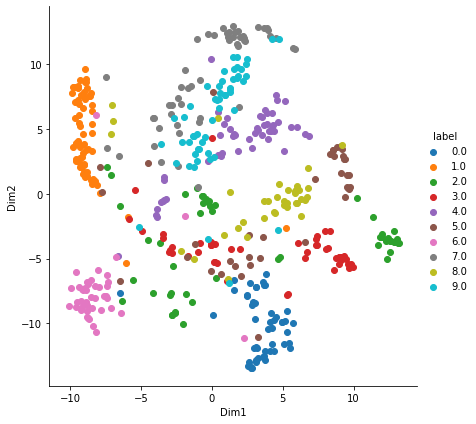

In [352]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Y = TSNE(principalComponents[:500,])
df = pd.DataFrame(data=np.c_[Y, labels[:500,]], columns=("Dim1", "Dim2", "label"))
sns.FacetGrid(df, hue="label", height=6).map(plt.scatter, "Dim1", "Dim2").add_legend()
plt.show()